In [2]:
import sys
sys.path.append('../')
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 6, 
                                   'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.fontsize' : 5.5,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

---
# Figure 1 - Dimensionality vs. encoding performance

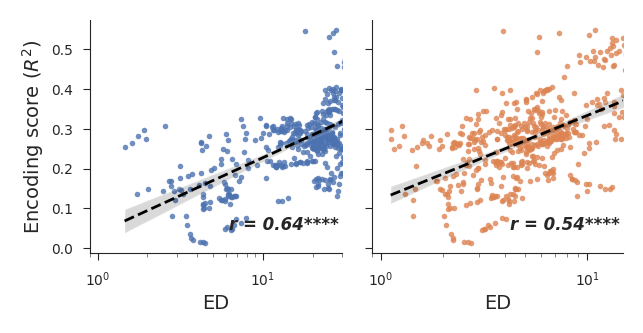

In [3]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, axs = plt.subplots(1, 2, figsize=(3.1, 1.55))

axs[0].set_xlim(0.9, 30)
sns.regplot(data=data, x='within-concept dimensionality (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[0])
axs[0].set(xlabel='ED', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', pos=(0.55, 0.1), ax=axs[0])

axs[1].set_xlim(0.9, 15)
sns.regplot(data=data, x='between-concept dimensionality', y='score', 
            logx=True, color=sns.color_palette()[1],
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[1])
axs[1].set(xlabel='ED', ylabel=None, yticklabels=[], xscale='log')
annotate_corr(data, x='between-concept dimensionality', y='score', pos=(0.55, 0.1), ax=axs[1])

plt.savefig('saved/appendix_01_ED-no-pool.png', dpi=300)
plt.show()

---
# Figure 1 - Dimensionality vs. encoding performance by layer

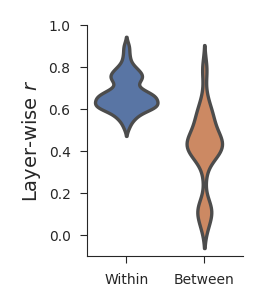

In [3]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r_within, p_within = stats.pearsonr(x['score'], x['within-concept dimensionality (mean)'])
    r_between, p_between = stats.pearsonr(x['score'], x['between-concept dimensionality'])
    return pd.DataFrame({'r_score_dim': [r_within, r_between], 'p_score_dim': [p_within, p_between], 'dim_type': ['within', 'between']})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'within-concept dimensionality (mean)', 'between-concept dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.2, 1.42))

sns.violinplot(data=data, y='r_score_dim', x='dim_type', inner=None, ax=ax)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', 
       xticklabels=['Within', 'Between'], ylim=(-.1, 1))

plt.savefig('saved/appendix_01_layerwise-no-pool.png', dpi=300)
plt.show()